# 第12回 ニューラルネットワークその2: 発展的な話題

いつものように右上の「Remix」ボタンを押して自分用の複製を作成すれば、各セルを「Shift+Enter」で実行しながら読むことができます

編集を行なった後は、Windowsでは「Ctrl+s」、Macでは「Cmd+s」で保存することができます

以下の畳み込みニューラルネットのコードは <https://github.com/FluxML/model-zoo/tree/master/vision/conv_mnist> を参考にシンプルに改変して利用しています

# 畳み込みニューラルネット (MNISTデータの識別)

ニューラルネットのパッケージであるFluxを使って、MNISTの画像の数字を畳み込みニューラルネットに認識させます

In [1]:
# 必要なパッケージを読み込みます
using Flux
using Flux: Data.DataLoader, Flux.Data.MNIST
using Flux: onehotbatch, onecold, crossentropy
using Flux: @epochs
using Statistics
using Plots

In [1]:
# Load train data
img = MNIST.images(:train)
labl = MNIST.labels(:train)

N = 5000 #訓練データのサイズ
x_train = zeros(Float32, 28, 28, 1, N)
for n = 1:size(x_train, 4)
  x_train[:, :, 1, n] .= float.(img[n])
end
y_train = onehotbatch(labl[1:N], 0:9)
onecold(y_train)

5000-element Array{Int64,1}:
  6
  1
  5
  2
 10
  3
  2
  4
  2
  5
  ⋮
  8
  9
  2
  1
  8
  4
  3
  2
  3

In [1]:
# Load test data
img = MNIST.images(:test)
labl = MNIST.labels(:test)

N = 1000 #テストデータのサイズ
x_test = zeros(Float32, 28, 28, 1, N)
for n = 1:size(x_test, 4)
  x_test[:, :, 1, n] .= float.(img[n])
end
y_test = onehotbatch(labl[1:N], 0:9)

10×1000 OneHotMatrix{Array{OneHotVector,1}}:
 0  0  0  1  0  0  0  0  0  0  1  0  0  …  0  0  0  0  0  1  0  0  0  1  0  0
 0  0  1  0  0  1  0  0  0  0  0  0  0     1  0  0  0  0  0  1  0  0  0  0  0
 0  1  0  0  0  0  0  0  0  0  0  0  0     0  0  1  0  0  0  0  1  1  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  1  0  0  0  0  0  0  0  0
 0  0  0  0  1  0  1  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  1  0  0  0  0  …  0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  1  0     0  1  0  0  0  0  0  0  0  0  0  0
 1  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  1  0
 0  0  0  0  0  0  0  1  0  1  0  0  1     0  0  0  0  1  0  0  0  0  0  0  1

In [1]:
# Create mini-batches
train_data = DataLoader((x_train, y_train), batchsize=128)

DataLoader{Tuple{Array{Float32,4},OneHotMatrix{Array{OneHotVector,1}}}}((Float32[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

Float32[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

Float32[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

...

Float32[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

Float32[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

Float32[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], Bool[0 1 … 0 0; 0 0 … 1 0; … ; 0 0 … 0 0; 0 0 … 0 0]), 128, 5000, true, 5000, [1, 2, 3, 4, 5, 6, 7, 8, 9, 10  …  4991, 4992, 4993, 4994, 4995, 4996, 4997, 4998, 4999, 5000], false)

今回用いる畳み込みニューラルネット LeNet の構造図です (model-zooより引用)

![LeNet-5.png](https://nextjournal.com/data/Qme9knvZiHVw6SgHPeULj4pm7tBDJAciTWBbGntkRKKNxm?content-type=image/png&node-id=1a6da170-bef9-43fd-b263-a335f30e0f7d&filename=LeNet-5.png&node-kind=file)


In [1]:
# Define model (LeNet)
model = Chain(
            Conv((5, 5), 1=>6, relu),
            MaxPool((2, 2)),
            Conv((5, 5), 6=>16, relu),
            MaxPool((2, 2)),
            flatten,
            Dense(prod([28÷4 - 3, 28÷4 - 3, 16]), 120, relu), 
            Dense(120, 84, relu), 
            Dense(84, 10)
          )

Chain(Conv((5, 5), 1=>6, relu), MaxPool((2, 2), pad = (0, 0, 0, 0), stride = (2, 2)), Conv((5, 5), 6=>16, relu), MaxPool((2, 2), pad = (0, 0, 0, 0), stride = (2, 2)), flatten, Dense(256, 120, relu), Dense(120, 84, relu), Dense(84, 10))

In [1]:
# Define loss function and optimizer
#loss(x, y) = Flux.crossentropy(model(x), y)
loss(x, y) = Flux.logitcrossentropy(model(x), y)

learning_rate = 0.01
opt = ADAM(learning_rate)
ps = Flux.params(model);

In [1]:
# 訓練前のモデルの数字認識の精度を計算します
mean(onecold(model(x_test)) .== onecold(y_test))

0.118

In [1]:
@epochs 100 Flux.train!(loss, ps, train_data, opt)

In [1]:
# 訓練後のモデルの数字認識の精度を計算します
mean(onecold(model(x_test)) .== onecold(y_test))

0.976

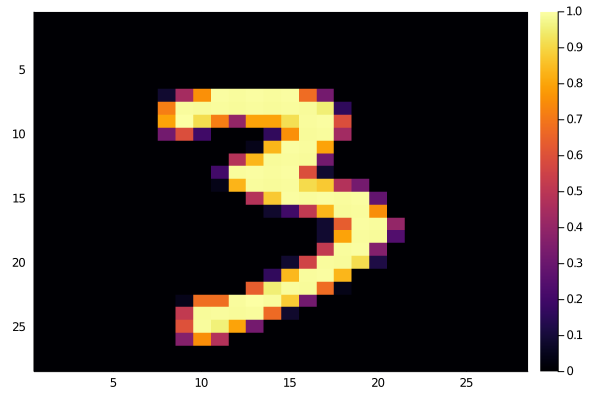

In [1]:
# 数字を認識できているか目で見て確認しましょう
iframe = 31
heatmap(reshape(x_test[:, :, 1, iframe], 28, 28), yflip=true)

In [1]:
onecold(model(x_test[:, :, 1:1, iframe:iframe])) .- 1

1-element Array{Int64,1}:
 3

# やってみよう

1つ目：中間層のkernelを可視化してみよう。あまり見てもわからないかもしれませんが。

In [1]:
i = 1 # 層インデックスの指定
j = 1 # channelインデックスの指定
heatmap(model[i].weight[:, :, 1, j])

1

2つ目：MNISTの畳み込みニューラルネットワークの性能(テストデータに対する認識率)をこれ以上向上させることができるかどうか、ハイパーパラメータを変えてみることで試してみてください。エポック数(epochs)、ミニバッチサイズ(batch_size)、学習率(learning_rate)を変えてみたり、訓練データのサイズを増やしてみるなどが考えられます。